# Molecular Solubility Regression

This project applies multiple linear regression to predict the log solubility of molecules using molecular descriptors. The dataset is from DeepChem.

Goals:
- Use subset of features to minimize prediction error
- Identify outliers and examine their properties

In [1]:
%%bash
wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2025-05-22 05:48:13--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

     0K .......... .......... .......... .......... .......... 52% 17.8M 0s
    50K .......... .......... .......... .......... ....      100% 60.9M=0.003s

2025-05-22 05:48:13 (26.7 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('delaney-processed.csv')
print(list(data))

['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


In [4]:
from sklearn.linear_model import LinearRegression

X = data[['Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']]
y = data['measured log solubility in mols per litre']


reg = LinearRegression().fit(X,y)
print(reg.coef_)
print(reg.intercept_)
y_predicted = reg.predict(X)
error = y - y_predicted
L2 = 0.5*np.mean(error**2)
print(L2)
# The mean squared error (MSE) gives us an indication of how well our model fits the data.

[-0.49921068 -0.01362162  0.07281654 -0.41338402 -0.14337233  0.03159255]
-0.009348960581832433
0.6901456049984575


In [22]:
from itertools import combinations

results = []

for n in range(2, len(features)+1):
    for subset in combinations(features, n):
        X_subset = data[list(subset)]
        model = LinearRegression().fit(X_subset, y)
        y_pred = model.predict(X_subset)
        error = y - y_pred
        L2 = 0.5 * np.mean(error**2)
        results.append((subset, L2))
        print(f"Features: {subset} → L2: {L2:.4f}")

# Best combination with the lowest L2 value
best_features, best_L2 = min(results, key=lambda x: x[1])
print("\nBest Feature Combination:")
print(f"{best_features} → L2: {best_L2:.4f}")

Features: ('Minimum Degree', 'Molecular Weight') → L2: 1.2137
Features: ('Minimum Degree', 'Number of H-Bond Donors') → L2: 2.0756
Features: ('Minimum Degree', 'Number of Rings') → L2: 1.6194
Features: ('Minimum Degree', 'Number of Rotatable Bonds') → L2: 1.9965
Features: ('Minimum Degree', 'Polar Surface Area') → L2: 2.1361
Features: ('Molecular Weight', 'Number of H-Bond Donors') → L2: 0.9698
Features: ('Molecular Weight', 'Number of Rings') → L2: 1.2616
Features: ('Molecular Weight', 'Number of Rotatable Bonds') → L2: 1.2955
Features: ('Molecular Weight', 'Polar Surface Area') → L2: 0.7771
Features: ('Number of H-Bond Donors', 'Number of Rings') → L2: 1.3877
Features: ('Number of H-Bond Donors', 'Number of Rotatable Bonds') → L2: 1.9495
Features: ('Number of H-Bond Donors', 'Polar Surface Area') → L2: 2.0930
Features: ('Number of Rings', 'Number of Rotatable Bonds') → L2: 1.3984
Features: ('Number of Rings', 'Polar Surface Area') → L2: 1.4274
Features: ('Number of Rotatable Bonds', 

In [6]:
# adding molecular name/ID
name = data['Compound ID']
X = np.c_[name,X]

In [25]:
# find top 5 molecule with largest prediction error
data['error'] = abs(y - y_predicted)
top5 = data.sort_values(by='error', ascending=False).head(5)
print(top5[['Compound ID', 'error']])

                                            Compound ID     error
1064                                        vamidothion  4.598973
555   Digoxin (L1=41,8mg/mL, L2=68,2mg/mL, Z=40,1mg/mL)  4.523947
852                                           uric acid  4.209220
292                                            Dimecron  4.205088
922                                          norbormide  4.098838


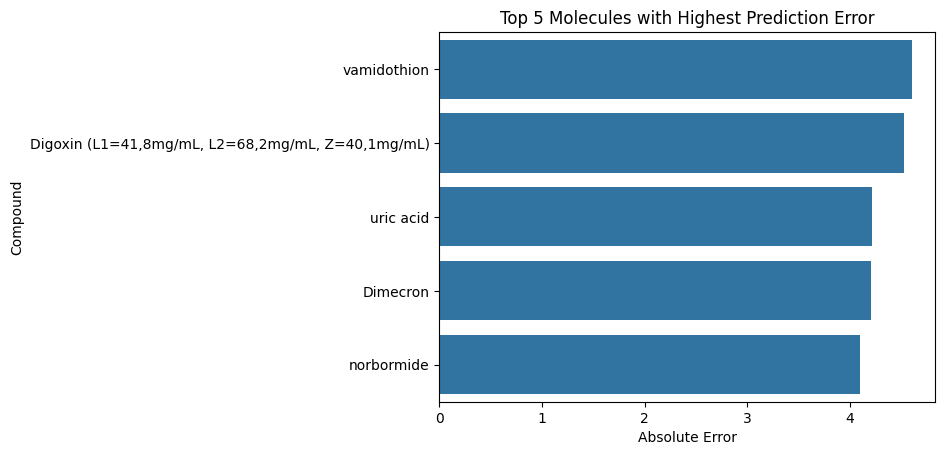

In [8]:
import seaborn as sns

top5_plot = top5.copy()
sns.barplot(data=top5_plot, x='error', y='Compound ID')
plt.title("Top 5 Molecules with Highest Prediction Error")
plt.xlabel("Absolute Error")
plt.ylabel("Compound")
plt.show()

## 💬 Analysis of Outliers
We examined the 5 molecules with the largest prediction errors:

* Digoxin and Uric Acid are biologically active compounds with multiple functional groups and complex hydrogen bonding behavior, which may not be fully captured by the descriptors used.

* Vamidothion, Dimecron, and Norbormide are pesticides with potentially large or unusual structures, including phosphate or bicyclic groups.

These molecules likely lie outside the domain of applicability of a simple linear model, suggesting that future work could benefit from:

* Non-linear models (e.g., decision trees or neural networks)

* Additional descriptors (e.g., 3D shape, partial charges, etc.)

* Feature engineering to better capture chemical behavior

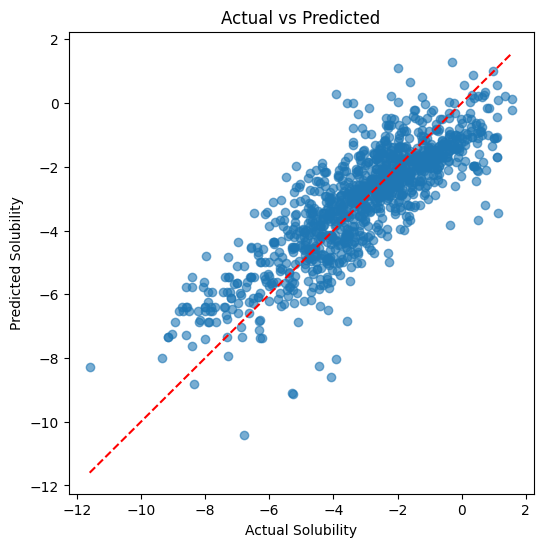

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y, y_predicted, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Actual vs Predicted")
plt.show()